##Ephemeris Generation##

This notebook is intended to test various methods of generating the positions and velocities of moving objects, including testing the accuracy of the resulting values calculated by interpolating between the points calculated by an n-body integrator. 

In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from itertools import repeat
import pyoorb as oo

from moo import MoOrbits, MoObs

In [4]:
orbitfile = 'pha20141031.des'
mo = MoObs()
mo.readOrbits(orbitfile)

In [5]:
print mo.orbits.dtype.names

('objId', 'q', 'e', 'inc', 'node', 'argPeri', 'tPeri', 'epoch', 'H', 'g', 'a', 'meanAnom')


In [6]:
# Set up to run OpenOrb to generate ephemerides.
mo.setupOorb()

Set up the times at which to calculate 'rough' positions. 
We will interpolate between these times to find the positions at the actual time of a visit. 

In [7]:
mo.setTimes(timestep=2./24., ndays=10, timestart=49353.16)

Python oorb element format: 
        # 
        # 0: orbitId  (cannot be a string)
        # 1 - 6: orbital elements, using radians for angles
        # 7: element type code 
        #       2 = cometary - means timescale is TT, too
        #       3 = keplerians - timescale?
        # 8: epoch
        # 9: timescale for the epoch; 1= MJD_UTC, 2=UT1, 3=TT, 4=TAI
        # 10: magHv
        # 11: G
        #
so we have to do a little translating from the orbits DataFrame to the elements we want in this array. 

In [9]:
sso = mo.orbits[0]
oorbelems = mo._packOorbElem(sso)

Python oorb ephem array format:

        #   [objid][time][ephemeris information @ that time]
        # 0 = distance (geocentric distance)
        # 1 = ra (deg)
        # 2 = dec (deg)
        # 3 = mag
        # 4 = ephem mjd
        # 5 = ephem mjd timescale
        # 6 = dra/dt (deg/day) sky motion
        # 7 = ddec/dt (deg/day) sky motion
        # 8 = phase angle (deg)
        # 9 = solar elongation angle (deg)
        
So usually we want to swap the axes at least, so that instead of all the ephemeris information @ a particular time being the accessible bit of information, we have all the RA values over time for a single object ('byObject')
Alternatively, we may want all the RA values for all objects at one time. This is also an option, by setting 'byObject' to False.

The ephemeris generation also returns an error code: err=0 means everything was successful.

In [12]:
oorbephs = mo._generateOorbEphs(oorbelems)
ephs = mo._unpackOorbEphs(oorbephs)

Interpolate between calculated ephemerides. This is where Steve Chesley suggests to use chevyshev polys instead of linear interpolation (thus letting us use bigger timesteps in the initial ephemeride generation). 
See SPKs generated by NAIF SPICE program (http://naif.jpl.nasa.gov/naif/tutorials.html)

In [14]:
# Currently linear interpolation
interpfuncs = mo.interpolateEphs(ephs)

In [16]:
orbsubset = mo.orbits[0:10]
ephTimes = mo.setTimes(timestep=2./24.0, ndays=365)
print len(mo.ephTimes.swapaxes(1, 0)[0])

4382


In [19]:
%%timeit
ephs = mo.generateEphs(orbsubset)

1 loops, best of 3: 7.91 s per loop


In [20]:
%%timeit
for sso in orbsubset:
    ephs = mo.generateEphs(sso)

1 loops, best of 3: 8.38 s per loop


It is indeed slightly faster (2.4s vs 2.55s for 30 objects, 7.9s vs 8.2s for 100 objects, 15.7s vs 16.6s for 200 objects) to calculate ephemerides for the combined set, rather than cycle through each one individually. However, there must be some balance here when considering many many objects, over a long time period (i.e. when doing big simulations for MAF or other purposes), as holding so many ephemerides in memory could be too big. 

[ 0.005   0.004   0.0047  0.0045] [ 0.08    0.079   0.079   0.0785]
Per object, grouping objects rather than looping is 5.74878557607 % faster.
 (difference is about  0.00455 s faster, out of 0.079125 s total time


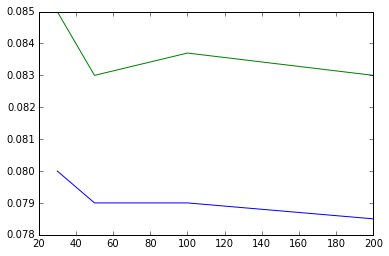

In [47]:
a = np.array([2.4, 3.95, 7.9, 15.7])
b = np.array([2.55, 4.15, 8.37, 16.6])
x = np.array([30, 50, 100, 200])
plt.plot(x, a/x)
plt.plot(x, b/x)
print (b/x - a/x), a/x
print 'Per object, grouping objects rather than looping is', np.mean((b/x-a/x) / (a/x) * 100), '% faster.'
print ' (difference is about ', np.mean(b/x-a/x), 's faster, out of', np.mean(a/x), 's total time'

In [24]:
# Set up for an accuracy test.
orbitfile = 'pha20141031.des'

mo = MoObs()
mo.readOrbits(orbitfile)
mo.setTimes(timestep=.2/24.0, ndays=0.02*365, timestart=51250.048523)
testEphTimes = np.copy(mo.ephTimes)
testtimes = testEphTimes.swapaxes(1, 0)[0]
mo.setTimes(timestep=2./24.0, ndays=365*10, timestart=49353.)
ephTimes = np.copy(mo.ephTimes)
print ephTimes.shape, testEphTimes.shape

print 'Test time range', testtimes.min(), testtimes.max()
print 'Time range for interpolation', ephTimes.swapaxes(1, 0)[0].min(), ephTimes.swapaxes(1, 0)[0].max()

sso = mo.orbits[np.where(mo.orbits['objId']==151)]
print sso

(43802, 2) (878, 2)
Test time range 51250.0401897 51257.348523
Time range for interpolation 49352.9166667 53003.0000001
[ (151, 0.868927899052464, 0.39811166, 3.445779, 268.945716, 80.767267, 49334.486277609714, 49353.16, 20.0, 0.15, 0.6215010745654349, 37.564736648097856)]


In [27]:
for orb in [sso]:
    mo.ephTimes = ephTimes
    ephs = mo.generateEphs(sso)
    interpfuncs = mo.interpolateEphs(ephs)
    print ephs['time'].min(), ephs['time'].max()
    # Evaluate errors
    mo.ephTimes = testEphTimes
    testephs = mo.generateEphs(sso)
    diff = {}
    for col in testephs.dtype.names:
        if col == 'time':
            continue
        val = interpfuncs[col](testtimes)
        diff[col] = val - testephs[col][0]

49352.9166667 53003.0000001


In [28]:
# Verify small errors
for col in diff:
    print col, diff[col].max(), diff[col].min()

magV 2.14996119752e-06 -1.77418390734e-06
dradt 0.000242152958865 -0.000242380016555
solarelon 2.66055724634e-05 -3.12767863431e-05
ra 186.380912561 -3.99699320021e-05
delta 1.36270387063e-06 -1.13250012235e-06
phase 2.79697614118e-05 -3.7124589543e-05
velocity 0.00022159001547 -0.000222414276882
ddecdt 2.04741067977e-05 -1.98944093081e-05
dec 5.60577416486e-07 -5.94025897183e-06


In [29]:
# And double-check on the position at a particular time.
time = 51250.048523000005
print interpfuncs['ra'](time), interpfuncs['solarelon'](time), time

150.408989088 8.85092436056 51250.048523


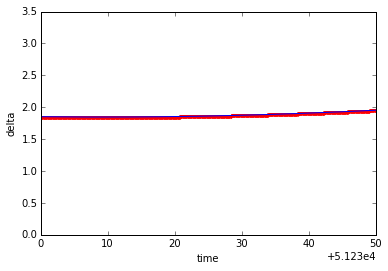

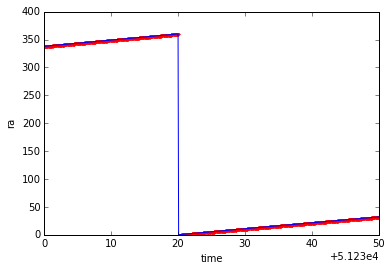

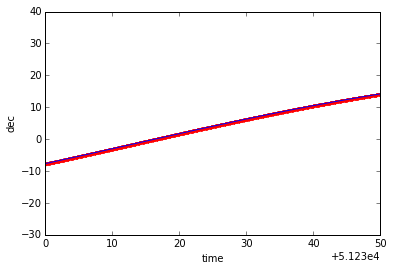

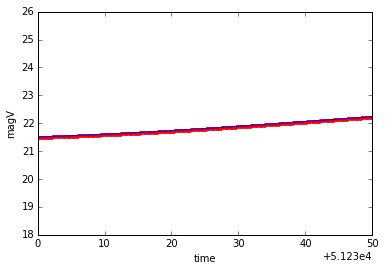

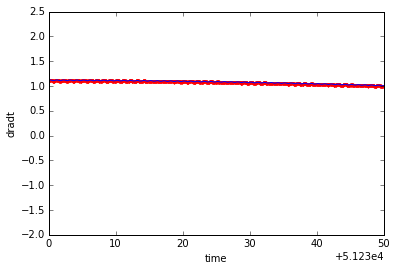

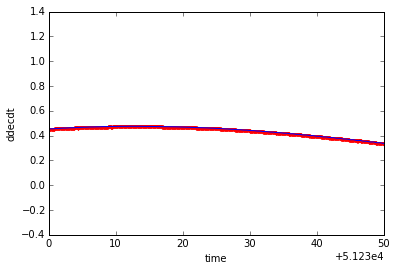

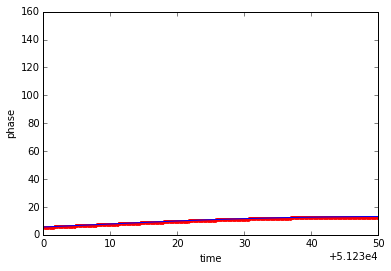

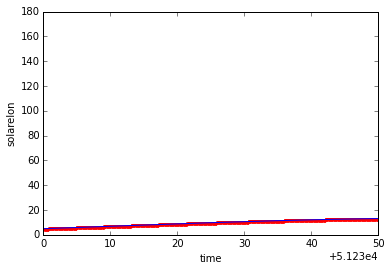

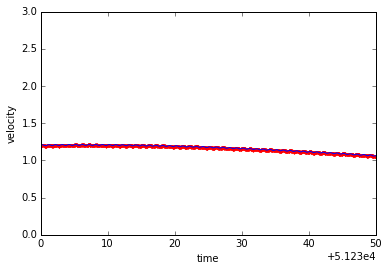

In [30]:
for col in ephs.dtype.names:
    if col == 'time':
        continue
    plt.figure()
    plt.plot(ephs['time'][0], ephs[col][0], 'r.')
    if col in interpfuncs:
        plt.plot(ephs['time'][0], interpfuncs[col](ephs['time'][0]), 'b-')
    plt.xlabel('time')
    plt.ylabel(col)
    plt.xlim(51230, 51280)

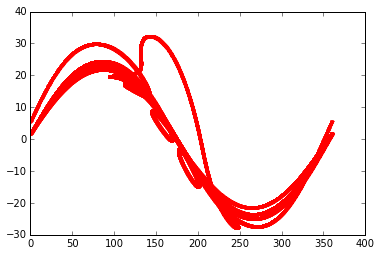

In [31]:
plt.plot(ephs['ra'][0], ephs['dec'][0], 'r.')

In [32]:
print interpfuncs.keys()

['magV', 'dradt', 'solarelon', 'ra', 'delta', 'phase', 'velocity', 'ddecdt', 'dec']


In [35]:
# Test Ceres against Horizons predictions (in particular solar elongation)
ceres = MoObs()
ceres.readOrbits('ceres.des')
print ceres.orbits['g']

[ 0.15]


In [37]:
ceres.setTimes(timestep=1, timestart=57209.0, ndays=365*10)
ceres_ephs = ceres.generateEphs()

In [38]:
import pandas as pd
ceph = pd.read_csv('horizons_ceres.txt', skipinitialspace=True)

In [39]:
ceph.head(3)

,Date__(UT)__HR:MN,Date_________JDUT,Unnamed: 2,Unnamed: 3,R.A._(ICRF/J2000.0),DEC_(ICRF/J2000.0),Azi_(a-app),Elev_(a-app),L_Ap_Sid_Time,a-mass,mag_ex,APmag,S-brt,delta,deldot,S-O-T,/r,S-T-O,Unnamed: 18
0,2015-Jul-07 00:00,2457210.5,NaN,NaN,310.76941,-28.33796,118.0097,8.2268,14.256117,6.606,0.978,7.74,6.63,1.975163,-7.860556,156.6349,/L,7.8973,NaN
1,2015-Jul-08 00:00,2457211.5,NaN,NaN,310.58748,-28.44778,117.5918,9.1740,14.321826,5.991,0.887,7.72,6.62,1.970951,-7.425822,157.6316,/L,7.5751,NaN
2,2015-Jul-09 00:00,2457212.5,NaN,NaN,310.40096,-28.55730,117.1793,10.1270,14.387534,5.476,0.811,7.70,6.60,1.966992,-6.985891,158.6182,/L,7.2543,NaN


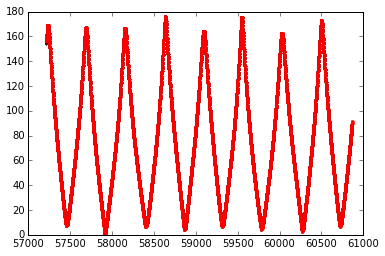

In [41]:
plt.plot(ceres_ephs[0]['time'], ceres_ephs[0]['solarelon'], 'k.')
plt.plot(ceph['Date_________JDUT']-2400000.5, ceph['S-O-T'], 'r.')